In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import warnings
from keras.applications.mobilenet_v2 import preprocess_input

In [2]:
#if you dont have tensorflow-gpu, comment this out/dont run this cell
a = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(a[0], True)

In [3]:
#ignore duplicate warnings
warnings.filterwarnings('ignore')

In [4]:
#Reduce if you get Out of Resources error, increase if your computer slows to a halt
BATCH_SIZE = 4

In [5]:
#find the file names of all the xray images
filelist_c = glob.glob('input/china_xrays/*.png')
filelist_m = glob.glob('input/montgomery_xrays/*.png')
filelist = filelist_c + filelist_m

In [6]:
#using regex, find the target feature of each image
labels = []
for file in filelist:
    #regex to find target
    #[0-9]{4} is the initial 4 numbers after the first underscore, (.+?) to find whatever is between "####_" and ".png"
    current_label = re.findall('[0-9]{4}_(.+?).png', file)
    labels.append(current_label[0])

In [8]:
#make dataframe of all the data
df = pd.DataFrame(filelist, columns=['file'])
df['target'] = labels

In [9]:
valdf = pd.DataFrame()
#split original dataframe of all data into a testing dataframe and a training dataframe
fulltraindf, testdf = train_test_split(df, stratify = df['target'], test_size=0.1)
print(fulltraindf)
def makedfs(fulltraindf=fulltraindf):
    #split training dataframe into training dataframe and validation dataframe
    traindf, valdf = train_test_split(fulltraindf, stratify = fulltraindf['target'], test_size = 0.1)
    return traindf, valdf
traindf, valdf = makedfs(fulltraindf)

                                    file target
51   input/china_xrays\CHNCXR_0052_0.png      0
186  input/china_xrays\CHNCXR_0187_0.png      0
166  input/china_xrays\CHNCXR_0167_0.png      0
540  input/china_xrays\CHNCXR_0541_1.png      1
191  input/china_xrays\CHNCXR_0192_0.png      0
..                                   ...    ...
604  input/china_xrays\CHNCXR_0605_1.png      1
440  input/china_xrays\CHNCXR_0441_1.png      1
231  input/china_xrays\CHNCXR_0232_0.png      0
522  input/china_xrays\CHNCXR_0523_1.png      1
25   input/china_xrays\CHNCXR_0026_0.png      0

[720 rows x 2 columns]


In [9]:
makedfs(fulltraindf)
print(traindf)
print(testdf)
print(valdf)

                                         file target
273       input/china_xrays\CHNCXR_0274_0.png      0
477       input/china_xrays\CHNCXR_0478_1.png      1
418       input/china_xrays\CHNCXR_0419_1.png      1
27        input/china_xrays\CHNCXR_0028_0.png      0
34        input/china_xrays\CHNCXR_0035_0.png      0
..                                        ...    ...
59        input/china_xrays\CHNCXR_0060_0.png      0
457       input/china_xrays\CHNCXR_0458_1.png      1
278       input/china_xrays\CHNCXR_0279_0.png      0
380       input/china_xrays\CHNCXR_0381_1.png      1
698  input/montgomery_xrays\MCUCXR_0051_0.png      0

[648 rows x 2 columns]
                                         file target
508       input/china_xrays\CHNCXR_0509_1.png      1
573       input/china_xrays\CHNCXR_0574_1.png      1
449       input/china_xrays\CHNCXR_0450_1.png      1
522       input/china_xrays\CHNCXR_0523_1.png      1
76        input/china_xrays\CHNCXR_0077_0.png      0
..                    

In [10]:
#initialize imagedatagenerators. added some rotation, width/height shift, shear and zoom to help with overfitting
train_generator = ImageDataGenerator(rescale=1./255,
                                    horizontal_flip = True, 
                                    fill_mode = 'nearest', 
                                    cval = 0,
                                    rotation_range=0.05,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.05,
                                    zoom_range=0.05)
                                    
test_generator = ImageDataGenerator(rescale=1./255)

In [11]:
#create dataframeiterators for the model to train off of
train = train_generator.flow_from_dataframe(dataframe = traindf, class_mode = 'binary', x_col = 'file', y_col = 'target', shuffle = True, batch_size = BATCH_SIZE, target_size = (224,224), color_mode='grayscale')
val = train_generator.flow_from_dataframe(dataframe = valdf, class_mode = 'binary', x_col = 'file', y_col = 'target', shuffle = True, batch_size = BATCH_SIZE, target_size = (224,224), color_mode='grayscale')

Found 648 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.


In [12]:
#create & populate model
model = models.Sequential()
model.add(layers.Conv2D(8, (3,3), input_shape=(224,224,1)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.LayerNormalization())
model.add(layers.Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(layers.Dropout(0.1))
model.add(layers.LayerNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [13]:
#compile model with learning loss decay. loss function = binary because output is binary.
model.compile(optimizer=tf.keras.optimizers.Adam(tf.keras.optimizers.schedules.InverseTimeDecay(0.00001,decay_steps=train.samples//BATCH_SIZE,decay_rate=0.5,staircase=False)), 
              loss='binary_crossentropy',
              metrics=['acc',tf.keras.metrics.Recall()])

In [ ]:
#skip this cell if you want, its just to validate output of imagedatagenerators
image, label = val.next()
plt.imshow(image[0],cmap='gray')
#print(max(image[0]))
#print(min(image[0]))

In [14]:
class shuffle_on_epoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        makedfs()

In [22]:
#train model
hist = model.fit(train, epochs=25, steps_per_epoch=train.samples//BATCH_SIZE, verbose=1, validation_data=val, validation_steps=val.samples//BATCH_SIZE,callbacks=[shuffle_on_epoch(), tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/25
162/162 [==============================] - 69s 427ms/step - loss: 0.5455 - acc: 0.7377 - recall: 0.7375 - val_loss: 0.5759 - val_acc: 0.7500 - val_recall: 0.8000
Epoch 2/25
162/162 [==============================] - 74s 457ms/step - loss: 0.5159 - acc: 0.7485 - recall: 0.7375 - val_loss: 0.5313 - val_acc: 0.7361 - val_recall: 0.6571
Epoch 3/25
162/162 [==============================] - 67s 417ms/step - loss: 0.5131 - acc: 0.7562 - recall: 0.7406 - val_loss: 0.5262 - val_acc: 0.7222 - val_recall: 0.6857
Epoch 4/25
162/162 [==============================] - 67s 414ms/step - loss: 0.5236 - acc: 0.7623 - recall: 0.7625 - val_loss: 0.5116 - val_acc: 0.7917 - val_recall: 0.7429
Epoch 5/25
162/162 [==============================] - 67s 415ms/step - loss: 0.5264 - acc: 0.7562 - recall: 0.7437 - val_loss: 0.5561 - val_acc: 0.7361 - val_recall: 0.6857
Epoch 6/25
162/162 [==============================] - 67s 416ms/step - loss: 0.5344 - acc: 0.7469 - recall: 0.7094 - val_loss: 0.4864 -

In [ ]:
#evaluate model with test dataframe
test = test_generator.flow_from_dataframe(dataframe = testdf, class_mode='binary', x_col='file', y_col='target',shuffle=False, batch_size=BATCH_SIZE,target_size=(224,224))
test_loss, test_acc, test_recall = model.evaluate(test, batch_size=BATCH_SIZE)

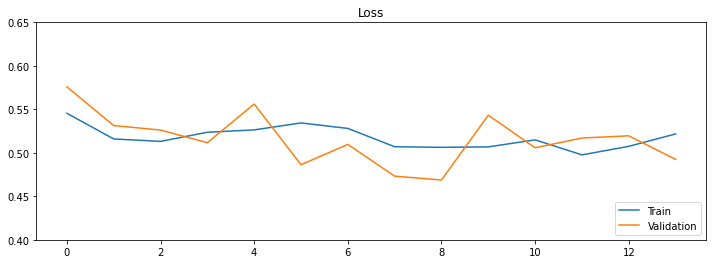

In [32]:
fig  = plt.figure(figsize=(12,4))
plt.title('Loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim([0.4,0.65])
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

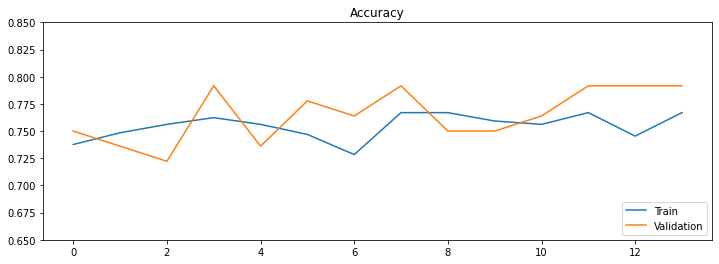

In [33]:
fig  = plt.figure(figsize=(12,4))
plt.title('Accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylim([0.65,0.85])
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

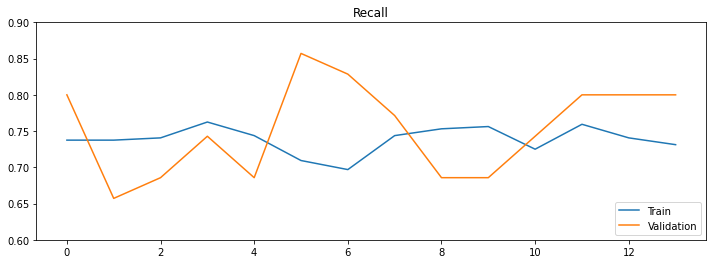

In [34]:
fig  = plt.figure(figsize=(12,4))
plt.title('Recall')
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.ylim([0.6,0.9])
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()